In [32]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import time
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import find_dotenv, load_dotenv
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

load_dotenv(find_dotenv())
sys.path.append(os.getenv('PROJECT_DIR'))

from src.metrics import bias, mae, mape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and Preprocess Data

In [9]:
# Load data
df = pd.read_csv("../data/raw/Air_Traffic_Passenger_Statistics.csv")

# Data Preprocessing
df['Activity Period Start Date'] = pd.to_datetime(df['Activity Period Start Date'])
df = df.groupby(by=['Activity Period Start Date']).agg({'Passenger Count': 'sum'}).reset_index()
df = df.rename(columns={
    "Activity Period Start Date": "date",
    "Passenger Count": "passenger_count"
})

# Split data Pre and Post Covid 19 Pandemic
1. The reason we split it because due to behavior of the passengers are different between pre and post Covid 19 Pandemic. 
2. From previous EDA, the trend of the data and the pattern of seasonality for both are different. 

In [11]:
# Split data between Pre and Post Covid 19 Pandemic
break_point = '2020-01-01'
df_pre_covid = df[df['date']<break_point]
df_post_covid = df[df['date']>=break_point]

# Split data for train and test
train_pre_covid = df_pre_covid[df_pre_covid['date']<='2019-01-01']
test_pre_covid = df_pre_covid[df_pre_covid['date']>'2019-01-01']
train_post_covid = df_post_covid[df_post_covid['date']<='2022-12-01']
test_post_covid = df_post_covid[df_post_covid['date']>'2022-12-01']

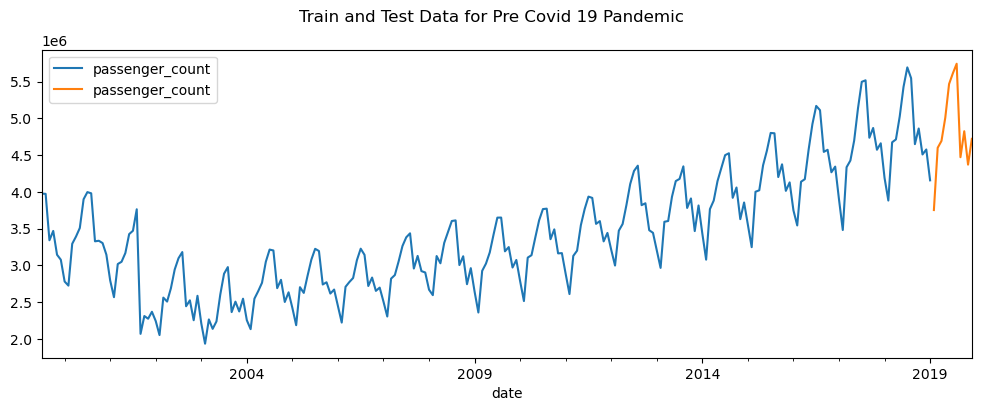

In [12]:
# Visualize Train and Testing Data for Pre Covid 19 Pandemic
fig, ax = plt.subplots(figsize=(12, 4))
train_pre_covid.set_index('date').plot(ax=ax, label='train')
test_pre_covid.set_index('date').plot(ax=ax, label='test')
fig.suptitle("Train and Test Data for Pre Covid 19 Pandemic")
plt.show()

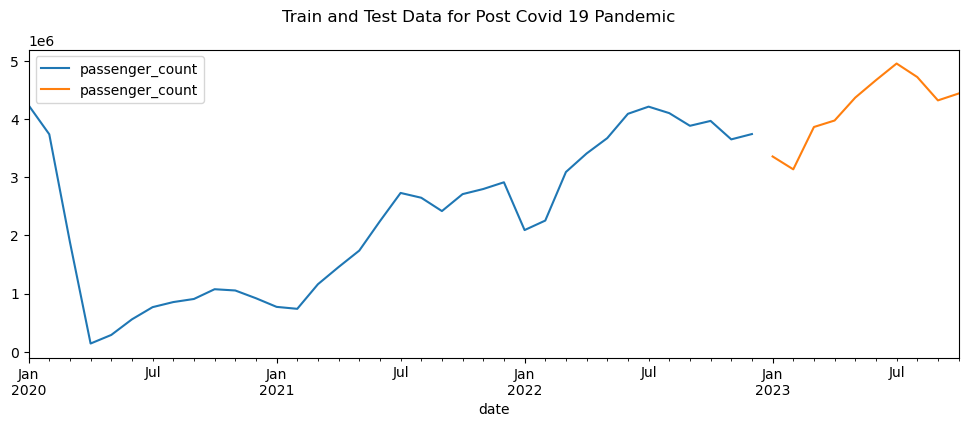

In [14]:
# Visualize Train and Testing Data for Post Covid 19 Pandemic
fig, ax = plt.subplots(figsize=(12, 4))
train_post_covid.set_index('date').plot(ax=ax, label='train')
test_post_covid.set_index('date').plot(ax=ax, label='test')
fig.suptitle("Train and Test Data for Post Covid 19 Pandemic")
plt.show()

# Check Stationarity of Our Dataset

In [15]:
adftest = adfuller(train_pre_covid['passenger_count'], autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -3.7773675461465617
P-Value: 0.017741844607067448
Number of lags: 13
Number of observations: 221
Critical Values: {'1%': -4.000328734182328, '5%': -3.430545275531156, '10%': -3.1388319837220435}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [16]:
adftest = adfuller(train_post_covid['passenger_count'], autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.6649103927926876
P-Value: 0.2509388993166092
Number of lags: 5
Number of observations: 30
Critical Values: {'1%': -4.2970953703703705, '5%': -3.5685571851851847, '10%': -3.2184266666666668}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


# Check Seasonality

## Seasonality Plot

In [17]:
def yearly_seasonality_plot(data, date_column, target, title):
    data = data
    data.loc[:, 'month'] = data[date_column].dt.month
    data.loc[:, 'year'] = data[date_column].dt.year
    ax = sns.lineplot(
        data=data,
        x='month',
        y=target,
        hue='year',
    )
    ax.set(
        title=title,
        xlabel='month',
        ylabel=target
    )
    plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_46032\3261133042.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'month'] = data[date_column].dt.month
C:\Users\USER\AppData\Local\Temp\ipykernel_46032\3261133042.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'year'] = data[date_column].dt.year


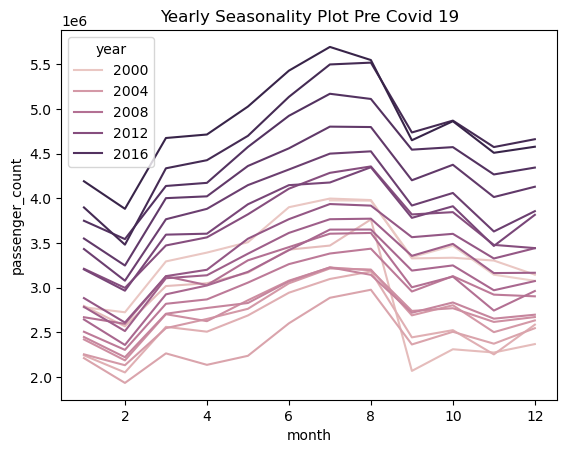

C:\Users\USER\AppData\Local\Temp\ipykernel_46032\3261133042.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'month'] = data[date_column].dt.month
C:\Users\USER\AppData\Local\Temp\ipykernel_46032\3261133042.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'year'] = data[date_column].dt.year


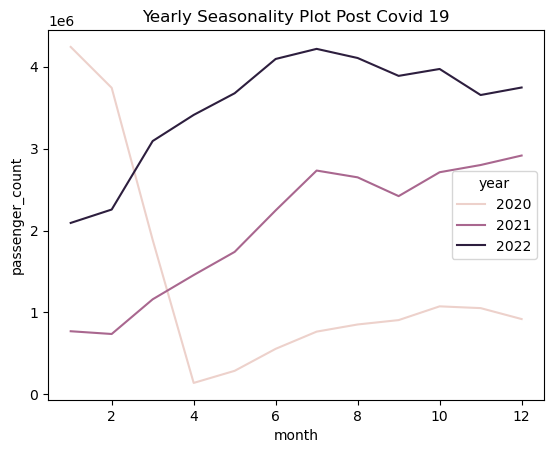

In [18]:
yearly_seasonality_plot(train_pre_covid, 'date', 'passenger_count', 'Yearly Seasonality Plot Pre Covid 19')
yearly_seasonality_plot(train_post_covid, 'date', 'passenger_count', 'Yearly Seasonality Plot Post Covid 19')

## Sub Series Seasonality Plots

In [19]:
def subseries_yearly_seasonality_plot(data, date_column, target, title):
    data = data
    data.loc[:, 'month'] = data[date_column].dt.month
    data.loc[:, 'year'] = data[date_column].dt.year
    mean_by_month = data.groupby(by='month').agg({'passenger_count': 'mean'})
    data = data.merge(mean_by_month, on='month', how='left')
    fg = sns.relplot(
        data=data,
        x='year',
        y='passenger_count_x',
        col='month',
        kind='line'
    )

    for i, ax in enumerate(fg.axes.flat):
        sns.lineplot(data=data[data['month']==i+1], x='year', y='passenger_count_y', color='orange', ax=ax)
    
    fg.figure.suptitle(title)
    plt.show()

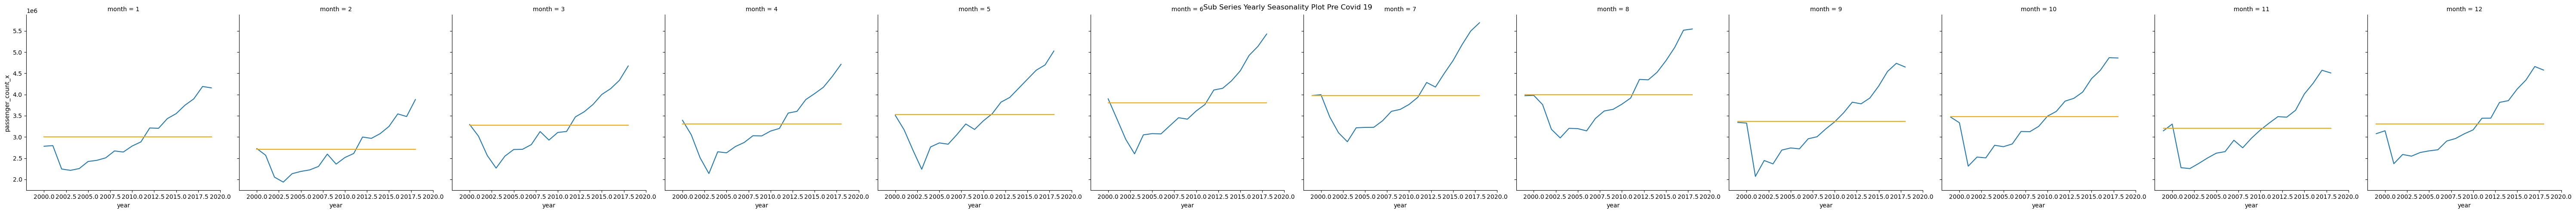

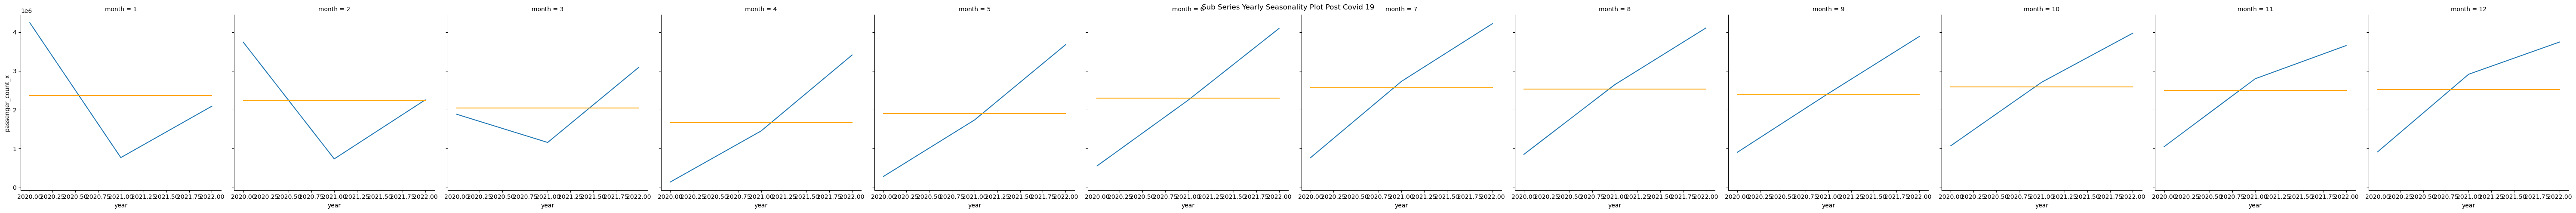

In [20]:
subseries_yearly_seasonality_plot(train_pre_covid, 'date', 'passenger_count', 'Sub Series Yearly Seasonality Plot Pre Covid 19')
subseries_yearly_seasonality_plot(train_post_covid, 'date', 'passenger_count', 'Sub Series Yearly Seasonality Plot Post Covid 19')

Explanation:
1. From the Pre Covid 19 Pandemic, there's a positive trend overtime and patten exists where the peck of the passenger count occurs in `August`.
2. From the Post Covid 19 Pandemic, there's a positive trend overtime (due to recovery from the pandemic), but there's no significant pattern.

## Autocorrelation and Partial Autocorrelation Plot

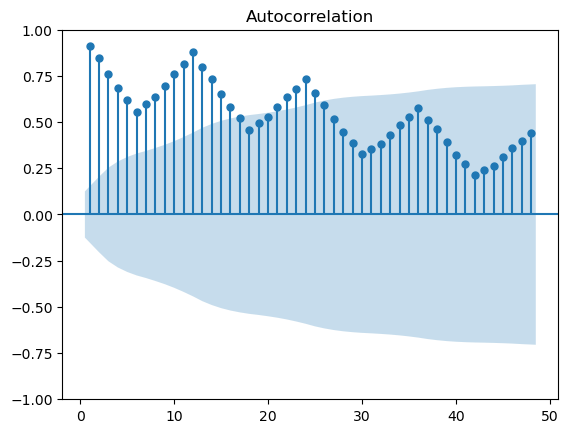

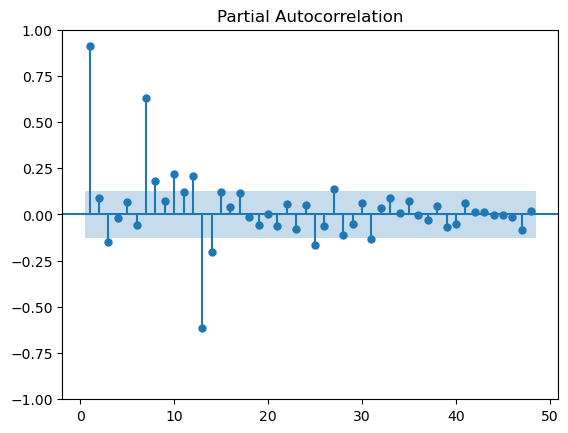

In [21]:
plot_acf(df_pre_covid['passenger_count'], zero=False, lags=48)
plot_pacf(df_pre_covid['passenger_count'], zero=False, lags=48)
plt.show()

Explanation:
1. ACF plot confirms the yearly seasonality because of the string correlation for at 12 lag interval

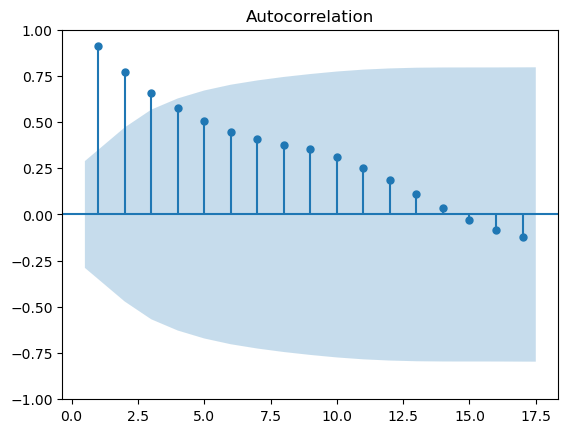

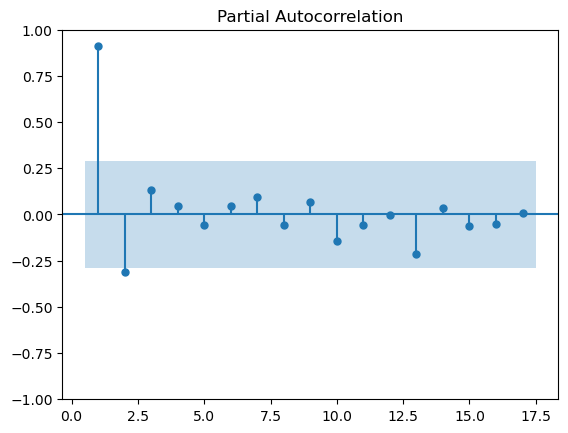

In [22]:
plot_acf(df_post_covid['passenger_count'], zero=False)
plot_pacf(df_post_covid['passenger_count'], zero=False)
plt.show()

Explanation:
1. Changing in behavior after the Covid 19 Pandemic which we can see that there's a `Tails-Off` at Autocorrelation Plot and `Cuts-Off` at Partial Autocorrelation plot. Suggesting a MA model

# Data Preparation for Modelling

In [23]:
# Split data between Pre and Post Covid 19 Pandemic
break_point = '2020-01-01'
df_pre_covid = df[df['date']<break_point]
df_post_covid = df[df['date']>='2020-04-01']

# Split data for train and test
train_pre_covid = df_pre_covid[df_pre_covid['date']<'2019-01-01'].set_index('date')
test_pre_covid = df_pre_covid[df_pre_covid['date']>='2019-01-01'].set_index('date')
train_post_covid = df_post_covid[df_post_covid['date']<'2023-01-01'].set_index('date')
test_post_covid = df_post_covid[df_post_covid['date']>='2023-01-01'].set_index('date')

# Modelling (Pre Covid) ARIMA

## Find Best Parameter

In [26]:
# find the best model for the ARIMA method
best_p, best_d, best_q = None, None, None
d=1
best_aic = float('inf')
for p in range(0, 4):
    for q in range(0, 4):
        model = ARIMA(
            endog=train_pre_covid,
            order=(p, d, q),
            freq='MS'
        )
        results = model.fit()
        if best_aic > results.aic:
            best_p, best_d, best_q = (p, d, q)
            best_aic = results.aic

print(f"Best Params (p, d, q): {(best_p, best_d, best_q)}")

# Train Arima Using The Best (p, d, s) Params
best_arima_model = ARIMA(
    endog=train_pre_covid,
    order=(best_p, best_d, best_q),
    freq='MS'
)
results = best_arima_model.fit()
# Predict Using ARIMA
prediction = results.get_forecast(steps=12).predicted_mean

c:\Users\USER\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USER\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USER\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USER\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USER\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\ts

Best Params (p, d, q): (3, 1, 2)


c:\Users\USER\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Plot the Results

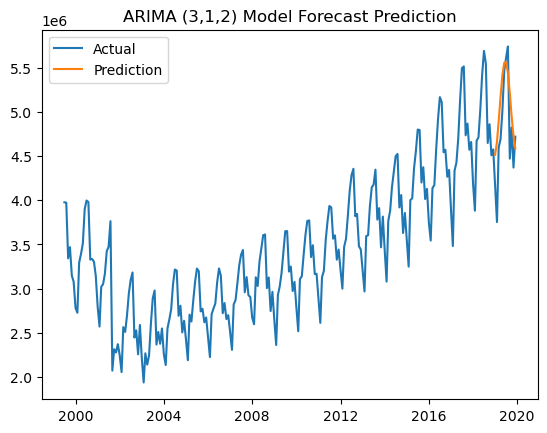

In [27]:
plt.plot(df_pre_covid['date'], df_pre_covid['passenger_count'], label='Actual')
plt.plot(prediction.index, prediction, label='Prediction')
plt.legend()
plt.title('ARIMA (3,1,2) Model Forecast Prediction')
plt.show()

## Analyze Residuals

In [34]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        passenger_count   No. Observations:                  234
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -3246.633
Date:                Mon, 15 Jan 2024   AIC                           6505.265
Time:                        22:14:52   BIC                           6525.971
Sample:                    07-01-1999   HQIC                          6513.615
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4631      0.035     41.392      0.000       1.394       1.532
ar.L2         -0.5448      0.061     -8.958      0.000      -0.664      -0.426
ar.L3         -0.2502      0.037     -6.820      0.000      -0.322      -0.178
ma.L1         -1.7640      0.062    -28.628      0.000      -1.885      -1.643
ma.L2          0.9944      0.066     14.989      0.000       0.864       1.124
sigma2      7.646e+10   1.29e-12   5.93e+22      0.000    7.65e+10    7.65e+10
===================================================================================
Ljung-Box (L1) (Q):                   9.50   Jarque-Bera (JB):               248.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -1.24
Prob(H) (two-sided):                  0.38   Kurtosis:                         7.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.77e+37. Standard errors may be unstable.
"""

Prob(Q) and Prob(JB) are 0 which means they both reject the null hypothesis which states that the residuals are `normally distributed` and `uncorrelated` 

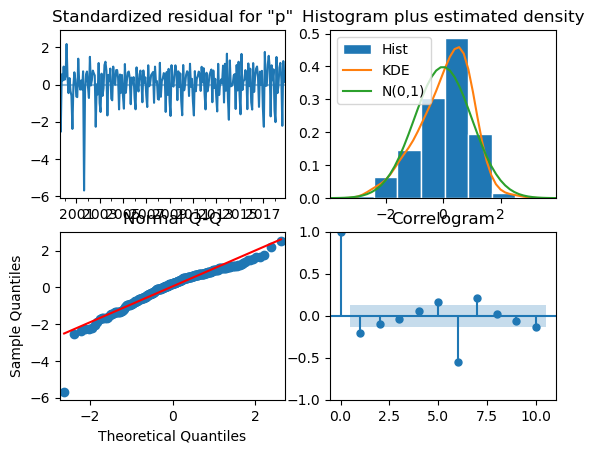

In [35]:
results.plot_diagnostics()
plt.show()

Explanation:
1. Upper left: the residuals are not at constant variance
2. Upper right and lower left: due to the the lines are quite far from each other, the dots are quite far away from from the expected red line
3. Lower right: the percentage of values that aren't significant is below 95%.

## Evaluate Results

In [36]:
print(f"Bias: {bias(test_pre_covid['passenger_count'], prediction):.2f}")
print(f"MAE: {mae(test_pre_covid['passenger_count'], prediction):.2f}")
print(f"MAPE: {mape(test_pre_covid['passenger_count'], prediction):.2f}%")

Bias: 274347.71
MAE: 354374.19
MAPE: 7.97%


# Modelling (Pre Covid) SARIMA

## Find Best Parameter

In [37]:
# find the best model for the ARIMA method
best_p, best_d, best_q = None, None, None
d=1
best_aic = float('inf')
for p in range(0, 7):
    for q in range(0, 7):
        model = ARIMA(
            endog=train_pre_covid,
            order=(p, d, q),
            seasonal_order=(0, 1, 0, 12),
            freq='MS'
        )
        results = model.fit()
        if best_aic > results.aic:
            best_p, best_d, best_q = (p, d, q)
            best_aic = results.aic

print(f"Best Params (p, d, q): {(best_p, best_d, best_q)}")

# Train Arima Using The Best (p, d, s) Params
best_arima_model = ARIMA(
    endog=train_pre_covid,
    order=(best_p, best_d, best_q),
    seasonal_order=(0, 1, 0, 12),
    freq='MS'
)
results = best_arima_model.fit()
# Predict Using ARIMA
prediction = results.get_forecast(steps=12).predicted_mean

c:\Users\USER\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USER\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USER\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USER\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USER\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\ts

## Plot the Results

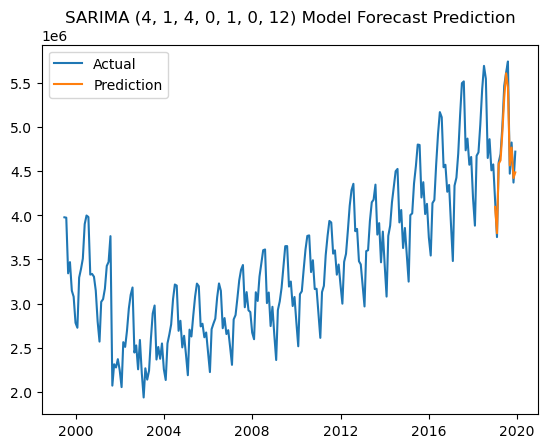

In [ ]:
plt.plot(df_pre_covid['date'], df_pre_covid['passenger_count'], label='Actual')
plt.plot(prediction.index, prediction, label='Prediction')
plt.legend()
plt.title('SARIMA (4, 1, 4, 0, 1, 0, 12) Model Forecast Prediction')
plt.show()

## Analyze Residuals

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                   passenger_count   No. Observations:                  234
Model:             ARIMA(3, 1, 2)x(0, 1, [], 12)   Log Likelihood               -2920.819
Date:                           Sun, 14 Jan 2024   AIC                           5853.638
Time:                                   22:14:06   BIC                           5874.027
Sample:                               07-01-1999   HQIC                          5861.870
                                    - 12-01-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8821      0.040    -47.416      0.000      -1.960      -1.804
ar.L2         -1.0363      0.062    -16.741      0.000      -1.158      -0.915
ar.L3         -0.0397      0.031     -1.287      0.198      -0.100       0.021
ma.L1          1.8358      0.030     62.191      0.000       1.778       1.894
ma.L2          0.9443      0.029     32.652      0.000       0.888       1.001
sigma2      1.862e+10   1.42e-12   1.31e+22      0.000    1.86e+10    1.86e+10
===================================================================================
Ljung-Box (L1) (Q):                   5.28   Jarque-Bera (JB):              2249.59
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.58e+37. Standard errors may be unstable.
"""

Prob(Q) and Prob(JB) are 0 which means they both reject the null hypothesis which states that the residuals are `normally distributed` and `uncorrelated` 

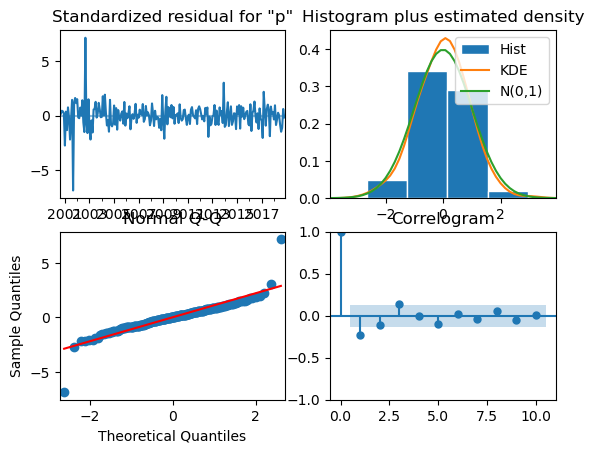

In [ ]:
results.plot_diagnostics()
plt.show()

Explanation:
1. Upper left: the residuals have constant variance
2. Upper right and lower left: due to the the lines are close each other, the dots are quite far away from from the expected red line
3. Lower right: the percentage of values that aren't significant is below 95%.

Overall it is better thatn using the ARIMA

## Evaluate Results

In [ ]:
print(f"Bias: {bias(test_pre_covid['passenger_count'], prediction):.2f}")
print(f"MAE: {mae(test_pre_covid['passenger_count'], prediction):.2f}")
print(f"MAPE: {mape(test_pre_covid['passenger_count'], prediction):.2f}%")

Bias: -45624.96
MAE: 90017.84
MAPE: 1.85%


Achieve better performance than ARIMA